In [1]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../src')
sys.path.append('../prompts')
sys.path.append('../src/llmperf')

# Run multiple models through the benchmarking process

In [2]:
# results_dir = '../data/results/samsung_switching_time/20250505-235504.835264'
# results_dir = '../data/results/samsung_switching_time/20250506-162308.625581'
# results_dir = '../data/results/samsung_switching_time/20250506-181608.028959'

results_dir = '../data/results/samsung_switching_time/20250507-194050.002042'

# Analyze metrics through models

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from benchmarking.utils import read_perf_eval_json_files

## Read the input json file

In [4]:
df = read_perf_eval_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.head(10)

NameError: name 'read_perf_eval_json_files' is not defined

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

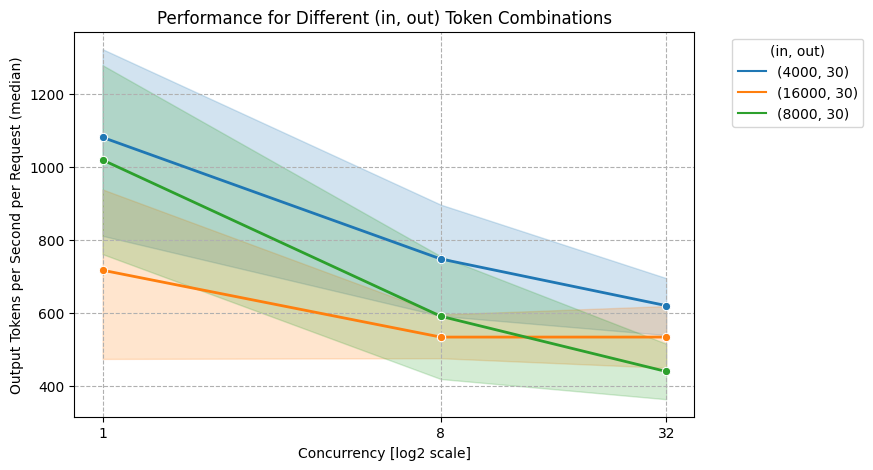

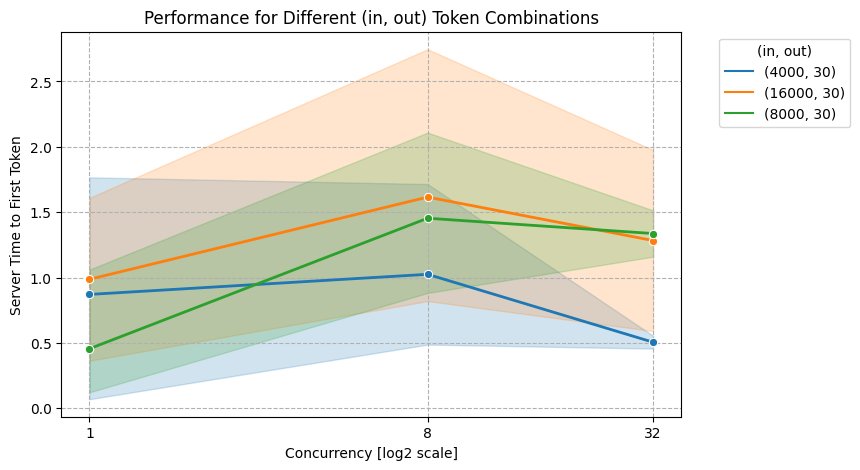

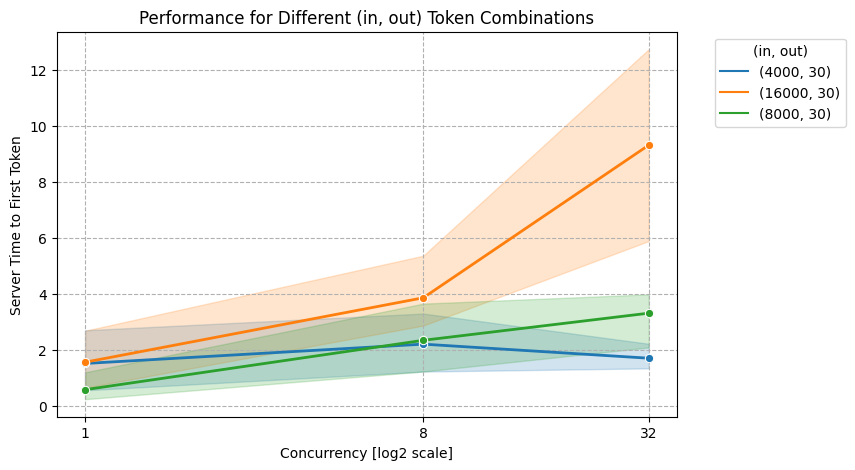

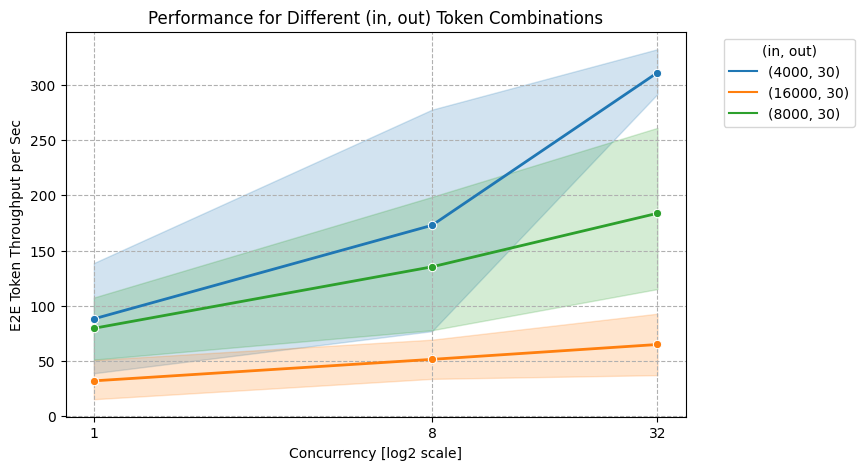

In [7]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_mean_output_token_per_s', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [4]:
import re
from typing import Optional

def find_uuid(file_name: str) -> Optional[str]:
    match = re.search(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}', file_name)
    uuid = None
    if match:
        uuid = match.group()
    else:
        raise ValueError(f"UUID not found in filename {file_name}")
        
    return uuid

# post processing individual request json files
def read_json_files_to_df(directory: str) -> pd.DataFrame:
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('individual_responses.json'):
            model_name = '_'.join(filename.split('_')[2:3])
            file_path = os.path.join(directory, filename)
            # Read the JSON file
            with open(file_path, 'r') as file:
                json_data = json.load(file)

                # Extract relevant fields from each JSON object and append to the data list
                for item in json_data:
                    if pd.isnull(item['error_code']):
                        data.append(
                            {
                                'start_time': item['start_time'],
                                'end_time': item['end_time'],
                                'server_ttft_s': item['server_ttft_s'],
                                'client_ttft_s': item['client_ttft_s'],
                                'model_name': model_name,
                                'uuid': find_uuid(filename),
                            }
                        )

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Get the DataFrame
df = read_json_files_to_df(results_dir)

# transforming str to date time for sorting
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['start_time'])

# transforming back to str for plotting
df['start_time_short'] = df['start_time'].dt.strftime(date_format='%H:%M:%S')
df

start_time         end_time  server_ttft_s  client_ttft_s  \
25 2025-05-07 19:49:06.652934  19:49:07.179722       0.308311       0.435614   
26 2025-05-07 19:49:07.181222  19:49:07.408090       0.085197       0.177272   
27 2025-05-07 19:49:07.409406  19:49:07.621238       0.085952       0.162950   
28 2025-05-07 19:49:07.622435  19:49:07.837502       0.085653       0.165514   
29 2025-05-07 19:49:07.839192  19:49:08.049629       0.084366       0.164287   
20 2025-05-07 19:49:11.382325  19:49:11.603987       0.085121       0.170300   
21 2025-05-07 19:49:11.605316  19:49:11.817962       0.085693       0.160682   
22 2025-05-07 19:49:11.819273  19:49:12.033647       0.085603       0.162867   
23 2025-05-07 19:49:12.035324  19:49:12.357757       0.085356       0.178451   
24 2025-05-07 19:49:12.358935  19:49:12.572091       0.085927       0.163500   
0  2025-05-07 19:49:15.789477  19:49:16.011148       0.085604       0.171744   
1  2025-05-07 19:49:16.013564  19:49:16.223190       0.086343       0.162440   
2  2025-05-07 19:49:16.224803  19:49:16.438223       0.085998       0.164531   
3  2025-05-07 19:49:16.443723  19:49:16.654834       0.085132       0.164895   
4  2025-05-07 19:49:16.656120  19:49:16.874977       0.084377       0.172958   
40 2025-05-07 19:49:20.201187  19:49:20.812192       0.411816       0.523206   
41 2025-05-07 19:49:20.813595  19:49:21.192240       0.206618       0.310276   
42 2025-05-07 19:49:21.194298  19:49:21.562302       0.205998       0.302905   
43 2025-05-07 19:49:21.565038  19:49:21.948226       0.206791       0.315061   
44 2025-05-07 19:49:21.949827  19:49:22.382298       0.205619       0.367498   
10 2025-05-07 19:49:25.860599  19:49:26.248015       0.207134       0.312264   
11 2025-05-07 19:49:26.249363  19:49:26.622960       0.206651       0.308101   
12 2025-05-07 19:49:26.624304  19:49:27.008350       0.206365       0.318067   
13 2025-05-07 19:49:27.009625  19:49:27.392370       0.205598       0.319122   
14 2025-05-07 19:49:27.393612  19:49:27.861112       0.206045       0.327450   
35 2025-05-07 19:49:31.213439  19:49:31.635077       0.207539       0.353777   
36 2025-05-07 19:49:31.636481  19:49:32.002465       0.206289       0.301495   
37 2025-05-07 19:49:32.004139  19:49:32.381835       0.205989       0.311342   
38 2025-05-07 19:49:32.383097  19:49:32.756971       0.206033       0.307426   
39 2025-05-07 19:49:32.758552  19:49:33.188092       0.205955       0.364277   
5  2025-05-07 19:49:36.668097  19:49:37.826888       0.805876       0.992325   
6  2025-05-07 19:49:37.828505  19:49:38.678716       0.593232       0.739785   
7  2025-05-07 19:49:38.680334  19:49:39.546962       0.594467       0.755084   
8  2025-05-07 19:49:39.548605  19:49:40.405723       0.594475       0.747179   
9  2025-05-07 19:49:40.408144  19:49:41.259564       0.592722       0.743230   
15 2025-05-07 19:49:44.759186  19:49:45.612496       0.592618       0.744918   
16 2025-05-07 19:49:45.613888  19:49:46.482343       0.594341       0.756857   
17 2025-05-07 19:49:46.483642  19:49:47.352611       0.593398       0.754912   
18 2025-05-07 19:49:47.354020  19:49:48.208779       0.594112       0.752355   
19 2025-05-07 19:49:48.210113  19:49:49.085643       0.592668       0.770045   
30 2025-05-07 19:49:52.525292  19:49:53.384559       0.593132       0.751950   
31 2025-05-07 19:49:53.386026  19:49:54.242745       0.593761       0.751402   
32 2025-05-07 19:49:54.244225  19:49:55.098292       0.594156       0.747853   
33 2025-05-07 19:49:55.099855  19:49:55.965753       0.594169       0.758390   
34 2025-05-07 19:49:55.967113  19:49:56.820464       0.593100       0.746604   

                    model_name                                  uuid  \
25  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
26  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
27  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
28  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3

In [5]:
# get df start times lower than 00:00:00
def get_start_times_lower_greater_than(df, time_str, type):
    # Convert the time_str to a datetime object for comparison
    time_obj = pd.to_datetime(time_str, format='%H:%M:%S').time()
    
    if type == 'lt':
        # Filter the DataFrame
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) < time_obj]
    elif type == 'gt':
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) > time_obj]
    else:
        return None
    return filtered_df

df_first_part = get_start_times_lower_greater_than(df, '22:00:00', 'gt')
df_first_part['start_time'] = df_first_part['start_time'].apply(lambda dt: dt.replace(day=5))

df_second_part = get_start_times_lower_greater_than(df, '22:00:00', 'lt')

df = pd.concat([df_first_part, df_second_part])

# Convert datetime to full string with microseconds
df['start_time_str'] = df['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

df

start_time         end_time  server_ttft_s  client_ttft_s  \
25 2025-05-07 19:49:06.652934  19:49:07.179722       0.308311       0.435614   
26 2025-05-07 19:49:07.181222  19:49:07.408090       0.085197       0.177272   
27 2025-05-07 19:49:07.409406  19:49:07.621238       0.085952       0.162950   
28 2025-05-07 19:49:07.622435  19:49:07.837502       0.085653       0.165514   
29 2025-05-07 19:49:07.839192  19:49:08.049629       0.084366       0.164287   
20 2025-05-07 19:49:11.382325  19:49:11.603987       0.085121       0.170300   
21 2025-05-07 19:49:11.605316  19:49:11.817962       0.085693       0.160682   
22 2025-05-07 19:49:11.819273  19:49:12.033647       0.085603       0.162867   
23 2025-05-07 19:49:12.035324  19:49:12.357757       0.085356       0.178451   
24 2025-05-07 19:49:12.358935  19:49:12.572091       0.085927       0.163500   
0  2025-05-07 19:49:15.789477  19:49:16.011148       0.085604       0.171744   
1  2025-05-07 19:49:16.013564  19:49:16.223190       0.086343       0.162440   
2  2025-05-07 19:49:16.224803  19:49:16.438223       0.085998       0.164531   
3  2025-05-07 19:49:16.443723  19:49:16.654834       0.085132       0.164895   
4  2025-05-07 19:49:16.656120  19:49:16.874977       0.084377       0.172958   
40 2025-05-07 19:49:20.201187  19:49:20.812192       0.411816       0.523206   
41 2025-05-07 19:49:20.813595  19:49:21.192240       0.206618       0.310276   
42 2025-05-07 19:49:21.194298  19:49:21.562302       0.205998       0.302905   
43 2025-05-07 19:49:21.565038  19:49:21.948226       0.206791       0.315061   
44 2025-05-07 19:49:21.949827  19:49:22.382298       0.205619       0.367498   
10 2025-05-07 19:49:25.860599  19:49:26.248015       0.207134       0.312264   
11 2025-05-07 19:49:26.249363  19:49:26.622960       0.206651       0.308101   
12 2025-05-07 19:49:26.624304  19:49:27.008350       0.206365       0.318067   
13 2025-05-07 19:49:27.009625  19:49:27.392370       0.205598       0.319122   
14 2025-05-07 19:49:27.393612  19:49:27.861112       0.206045       0.327450   
35 2025-05-07 19:49:31.213439  19:49:31.635077       0.207539       0.353777   
36 2025-05-07 19:49:31.636481  19:49:32.002465       0.206289       0.301495   
37 2025-05-07 19:49:32.004139  19:49:32.381835       0.205989       0.311342   
38 2025-05-07 19:49:32.383097  19:49:32.756971       0.206033       0.307426   
39 2025-05-07 19:49:32.758552  19:49:33.188092       0.205955       0.364277   
5  2025-05-07 19:49:36.668097  19:49:37.826888       0.805876       0.992325   
6  2025-05-07 19:49:37.828505  19:49:38.678716       0.593232       0.739785   
7  2025-05-07 19:49:38.680334  19:49:39.546962       0.594467       0.755084   
8  2025-05-07 19:49:39.548605  19:49:40.405723       0.594475       0.747179   
9  2025-05-07 19:49:40.408144  19:49:41.259564       0.592722       0.743230   
15 2025-05-07 19:49:44.759186  19:49:45.612496       0.592618       0.744918   
16 2025-05-07 19:49:45.613888  19:49:46.482343       0.594341       0.756857   
17 2025-05-07 19:49:46.483642  19:49:47.352611       0.593398       0.754912   
18 2025-05-07 19:49:47.354020  19:49:48.208779       0.594112       0.752355   
19 2025-05-07 19:49:48.210113  19:49:49.085643       0.592668       0.770045   
30 2025-05-07 19:49:52.525292  19:49:53.384559       0.593132       0.751950   
31 2025-05-07 19:49:53.386026  19:49:54.242745       0.593761       0.751402   
32 2025-05-07 19:49:54.244225  19:49:55.098292       0.594156       0.747853   
33 2025-05-07 19:49:55.099855  19:49:55.965753       0.594169       0.758390   
34 2025-05-07 19:49:55.967113  19:49:56.820464       0.593100       0.746604   

                    model_name                                  uuid  \
25  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
26  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
27  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
28  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3

In [12]:
# Initialize a column for the switching time
df['server_switching_time'] = None

# Group by model_name
grouped = df.groupby('uuid')

# Iterate through each group to calculate switching time
for name, group in grouped:
    if len(group) > 1:
        first_ttft = group['server_ttft_s'].iloc[0]
        # print(f'first_ttft {first_ttft}')
        mean_ttft = group['server_ttft_s'].iloc[1:].mean()
        # print(f'mean_ttft')
        std_ttft = group['server_ttft_s'].iloc[1:].std()
        # print(f'std_ttft {std_ttft}')
        std_ttft = 1e-16 if np.isnan(std_ttft) else std_ttft
        switching_time = first_ttft - mean_ttft
        print(f'first_ttft {first_ttft}')
        print(f'switching_time {switching_time}')
        print(f'{switching_time} > ({mean_ttft} + 3 * {std_ttft})')
        print(f'{first_ttft} > ({mean_ttft} + 3 * {std_ttft})')
        if first_ttft > (mean_ttft + 3 * std_ttft):
            df.loc[group.index[0], 'server_switching_time'] = switching_time
        else:
            None
    else:
        df.loc[group.index[0], 'server_switching_time'] = None

# with pd.option_context(
#     'display.max_rows',
#     None,
# ):
#     display(df)

first_ttft 0.20713376998901367
switching_time 0.0009691119194030762
0.0009691119194030762 > (0.2061646580696106 + 3 * 0.00045185377677567953)
0.20713376998901367 > (0.2061646580696106 + 3 * 0.00045185377677567953)
first_ttft 0.5926177501678467
switching_time -0.0010120272636413574
-0.0010120272636413574 > (0.593629777431488 + 3 * 0.0007565378389207258)
0.5926177501678467 > (0.593629777431488 + 3 * 0.0007565378389207258)
first_ttft 0.4118156433105469
switching_time 0.20555901527404785
0.20555901527404785 > (0.20625662803649902 + 3 * 0.0005444707136381241)
0.4118156433105469 > (0.20625662803649902 + 3 * 0.0005444707136381241)
first_ttft 0.08512067794799805
switching_time -0.0005240440368652344
-0.0005240440368652344 > (0.08564472198486328 + 3 * 0.00023566041404730358)
0.08512067794799805 > (0.08564472198486328 + 3 * 0.00023566041404730358)
first_ttft 0.593132495880127
switching_time -0.0006641745567321777
-0.0006641745567321777 > (0.5937966704368591 + 3 * 0.0005012805434179477)
0.5931324

In [9]:
df

start_time         end_time  server_ttft_s  client_ttft_s  \
25 2025-05-07 19:49:06.652934  19:49:07.179722       0.308311       0.435614   
26 2025-05-07 19:49:07.181222  19:49:07.408090       0.085197       0.177272   
27 2025-05-07 19:49:07.409406  19:49:07.621238       0.085952       0.162950   
28 2025-05-07 19:49:07.622435  19:49:07.837502       0.085653       0.165514   
29 2025-05-07 19:49:07.839192  19:49:08.049629       0.084366       0.164287   
20 2025-05-07 19:49:11.382325  19:49:11.603987       0.085121       0.170300   
21 2025-05-07 19:49:11.605316  19:49:11.817962       0.085693       0.160682   
22 2025-05-07 19:49:11.819273  19:49:12.033647       0.085603       0.162867   
23 2025-05-07 19:49:12.035324  19:49:12.357757       0.085356       0.178451   
24 2025-05-07 19:49:12.358935  19:49:12.572091       0.085927       0.163500   
0  2025-05-07 19:49:15.789477  19:49:16.011148       0.085604       0.171744   
1  2025-05-07 19:49:16.013564  19:49:16.223190       0.086343       0.162440   
2  2025-05-07 19:49:16.224803  19:49:16.438223       0.085998       0.164531   
3  2025-05-07 19:49:16.443723  19:49:16.654834       0.085132       0.164895   
4  2025-05-07 19:49:16.656120  19:49:16.874977       0.084377       0.172958   
40 2025-05-07 19:49:20.201187  19:49:20.812192       0.411816       0.523206   
41 2025-05-07 19:49:20.813595  19:49:21.192240       0.206618       0.310276   
42 2025-05-07 19:49:21.194298  19:49:21.562302       0.205998       0.302905   
43 2025-05-07 19:49:21.565038  19:49:21.948226       0.206791       0.315061   
44 2025-05-07 19:49:21.949827  19:49:22.382298       0.205619       0.367498   
10 2025-05-07 19:49:25.860599  19:49:26.248015       0.207134       0.312264   
11 2025-05-07 19:49:26.249363  19:49:26.622960       0.206651       0.308101   
12 2025-05-07 19:49:26.624304  19:49:27.008350       0.206365       0.318067   
13 2025-05-07 19:49:27.009625  19:49:27.392370       0.205598       0.319122   
14 2025-05-07 19:49:27.393612  19:49:27.861112       0.206045       0.327450   
35 2025-05-07 19:49:31.213439  19:49:31.635077       0.207539       0.353777   
36 2025-05-07 19:49:31.636481  19:49:32.002465       0.206289       0.301495   
37 2025-05-07 19:49:32.004139  19:49:32.381835       0.205989       0.311342   
38 2025-05-07 19:49:32.383097  19:49:32.756971       0.206033       0.307426   
39 2025-05-07 19:49:32.758552  19:49:33.188092       0.205955       0.364277   
5  2025-05-07 19:49:36.668097  19:49:37.826888       0.805876       0.992325   
6  2025-05-07 19:49:37.828505  19:49:38.678716       0.593232       0.739785   
7  2025-05-07 19:49:38.680334  19:49:39.546962       0.594467       0.755084   
8  2025-05-07 19:49:39.548605  19:49:40.405723       0.594475       0.747179   
9  2025-05-07 19:49:40.408144  19:49:41.259564       0.592722       0.743230   
15 2025-05-07 19:49:44.759186  19:49:45.612496       0.592618       0.744918   
16 2025-05-07 19:49:45.613888  19:49:46.482343       0.594341       0.756857   
17 2025-05-07 19:49:46.483642  19:49:47.352611       0.593398       0.754912   
18 2025-05-07 19:49:47.354020  19:49:48.208779       0.594112       0.752355   
19 2025-05-07 19:49:48.210113  19:49:49.085643       0.592668       0.770045   
30 2025-05-07 19:49:52.525292  19:49:53.384559       0.593132       0.751950   
31 2025-05-07 19:49:53.386026  19:49:54.242745       0.593761       0.751402   
32 2025-05-07 19:49:54.244225  19:49:55.098292       0.594156       0.747853   
33 2025-05-07 19:49:55.099855  19:49:55.965753       0.594169       0.758390   
34 2025-05-07 19:49:55.967113  19:49:56.820464       0.593100       0.746604   

                    model_name                                  uuid  \
25  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
26  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
27  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3-852e-5d8c9e2ab0d0   
28  Meta-Llama-3-1-8B-Instruct  7f5d5936-01db-4cd3

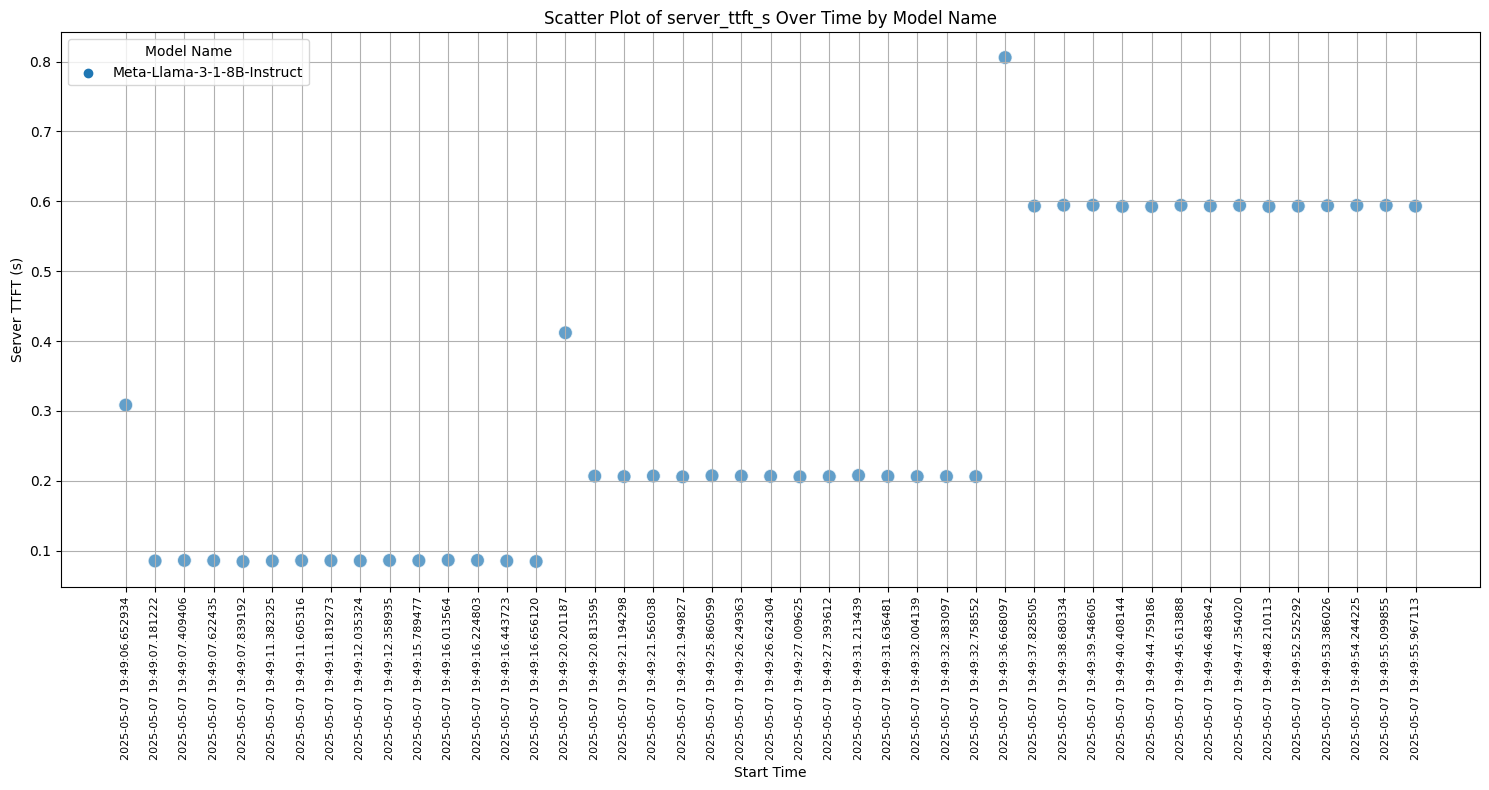

In [13]:
# Create a scatter plot
plt.figure(figsize=(15, 8))
sns.scatterplot(x='start_time_str', y='server_ttft_s', hue='model_name', data=df, s=100, alpha=0.7)

# Customize the plot
plt.title('Scatter Plot of server_ttft_s Over Time by Model Name')
plt.xlabel('Start Time')
plt.ylabel('Server TTFT (s)')
plt.legend(title='Model Name', loc='upper left')
plt.xticks(rotation='vertical', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

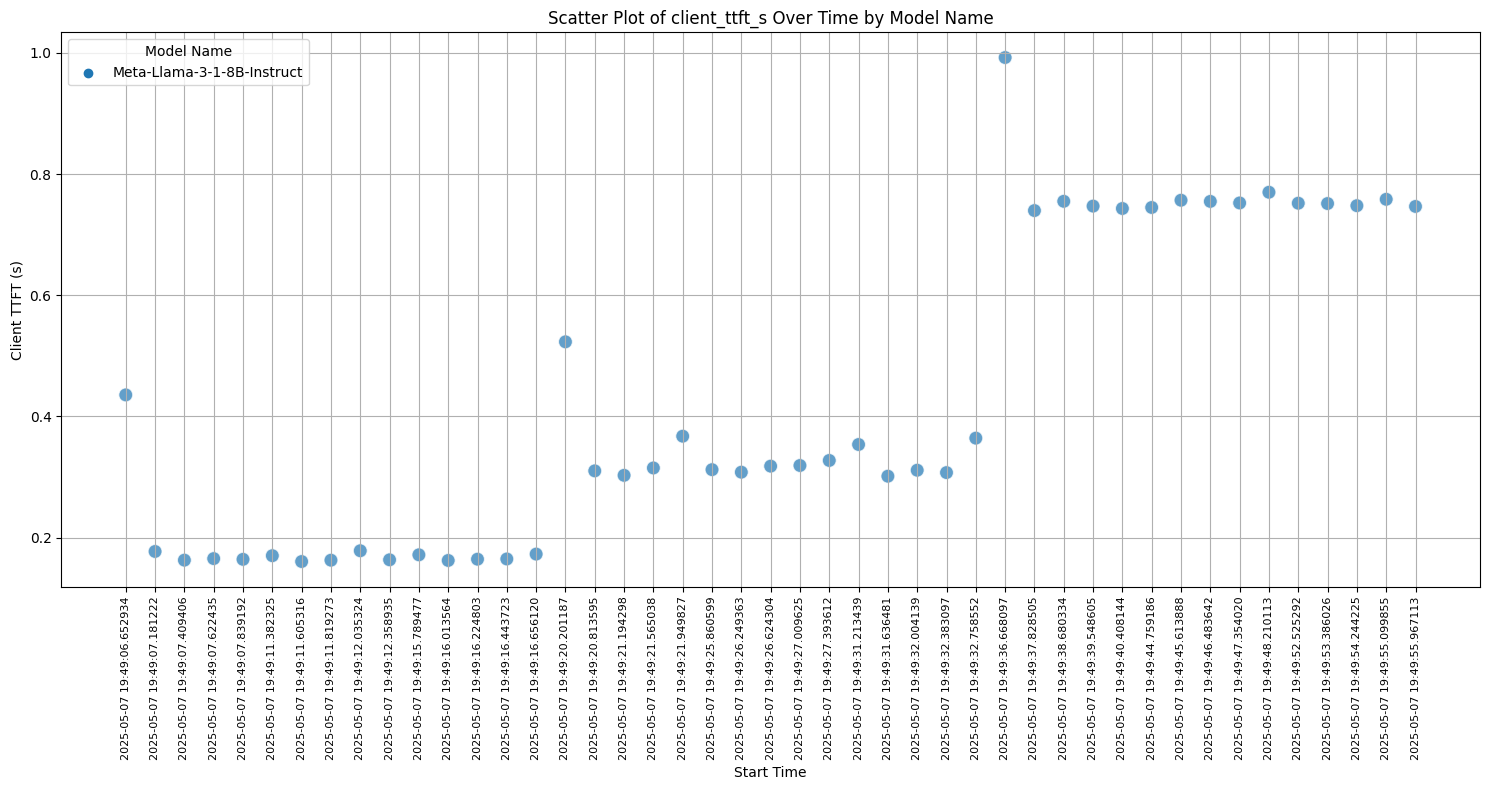

In [14]:
# Create a scatter plot
plt.figure(figsize=(15, 8))
sns.scatterplot(x='start_time_str', y='client_ttft_s', hue='model_name', data=df, s=100, alpha=0.7)

# Customize the plot
plt.title('Scatter Plot of client_ttft_s Over Time by Model Name')
plt.xlabel('Start Time')
plt.ylabel('Client TTFT (s)')
plt.legend(title='Model Name', loc='upper left')
plt.xticks(rotation='vertical', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()